In [19]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
image_input_path = "2A2X.png"

In [3]:
cv2.__version__

'3.3.0'

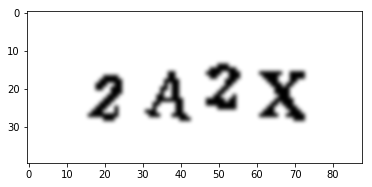

In [60]:
img = cv2.imread(image_input_path)
# to grey scale
grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
# add frame
white = [255,255,255]
grey = cv2.copyMakeBorder(grey, 8, 8, 8, 8, cv2.BORDER_CONSTANT, value = white)
# Adaptive Thresholding
# Converting color to only black and white
th = cv2.adaptiveThreshold(grey,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
plt.imshow(th, cmap = 'gray',interpolation = 'bicubic')
plt.show()